In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib_inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
import seaborn as sns

In [2]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")

In [3]:
df1.groupby('area_type')['area_type'].agg('count')  #to see how many variables are there in perticular column

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [4]:
df2 = df1.drop(['area_type','availability','society','balcony'], axis='columns')   #drop the useless columns
df3=df2.dropna() 

In [5]:
#df3.groupby('size')['size'].agg('count')

df3['BHK'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

C:\Users\Shikha\AppData\Local\Temp/ipykernel_10780/2140598472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['BHK'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


In [6]:
#so in the above line run we will see there is one home with 43 bedroom in 2400 sqft which is kind of an error, which we need to clean


#we will see some value which is in range

def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [7]:
#taking the avg of range
def convert_sqft_to_num(x):
    token=x.split('-')
    if len(token)==2:
        return (float(token[0])+float(token[1]))/2
    try:
        return float(x)
    except:
        return None

In [8]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
#lets check

In [9]:
#getting the price per sqft
df5 = df4.copy()
df5['price_per_sqft'] = (df5['price']*100000)/df5['total_sqft']

In [10]:
#lets handle categorical data - location
#first we will handle extra spaces
df5.location = df5.location.apply(lambda x:x.strip())
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending= False)
#this will give you different location name with number of rows

In [11]:
location_stats_less_than_10 = location_stats[location_stats<=10]

In [12]:
df5.location= df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x )

In [13]:
#outlier detection

df6 = df5[~(df5.total_sqft/df5.BHK<300)]

In [14]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df], ignore_index=True)
    return df_out

In [15]:
df7 = remove_pps_outliers(df6)

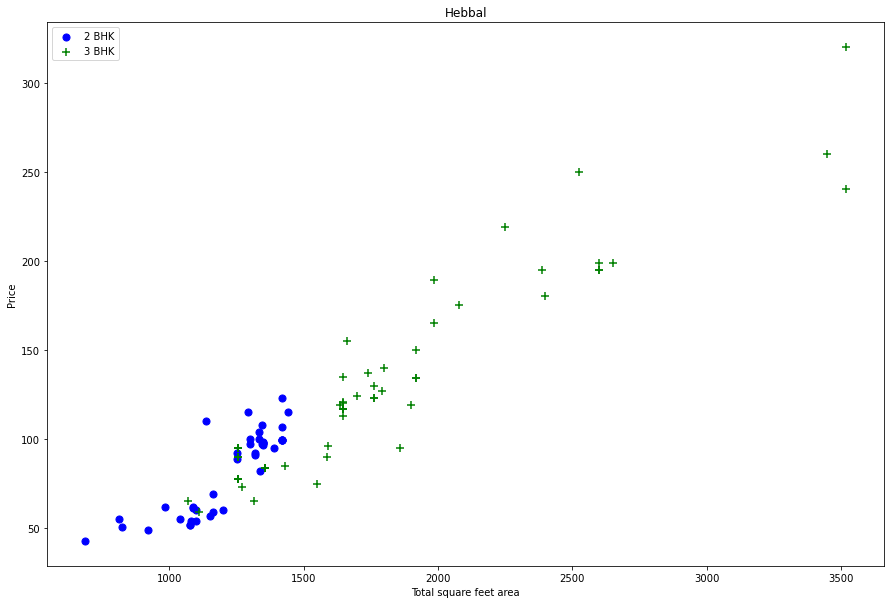

In [16]:
def pot_scatter_chart(df,location):
    BHK2 = df[(df.location==location) & (df.BHK==2)]
    BHK3 = df[(df.location==location) & (df.BHK==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(BHK2.total_sqft,BHK2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(BHK3.total_sqft,BHK3.price,marker='+',color='green',label='3 BHK', s=50)
    plt.xlabel("Total square feet area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()
pot_scatter_chart(df7,"Hebbal")

In [17]:
def remove_BHK_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
       BHK_stats = {}
       for BHK, BHK_df in location_df.groupby('BHK'):
            BHK_stats[BHK] = {
                'mean': np.mean(BHK_df.price_per_sqft),
                'std': np.std(BHK_df.price_per_sqft),
                'count': BHK_df.shape[0]
            }
    for BHK, BHK_df in location_df.groupby('BHK'):
            stats = BHK_stats.get(BHK-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, BHK_df[BHK_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [18]:
df8 = remove_BHK_outliers(df7)
#pot_scatter_chart(df8,"Hebbal")  

In [19]:
# plt.hist(df8.bath,rwidth=0.8)
# plt.xlabel("Number of bathrooms")
# plt.ylabel("count")


df9 = df8[df8.bath<df8.BHK+2]

df10 = df9.drop(['size','price_per_sqft'],axis='columns')

In [20]:
#model building
dummies = pd.get_dummies(df10.location)
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')

df12 = df11.drop('location', axis='columns')

In [21]:
X = df12.drop('price',axis='columns')
y = df12.price

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10) 

In [23]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test, y_test)

0.7978496445893964

In [24]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

In [25]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.83766773, 0.78497492, 0.84105502, 0.83425791, 0.80082091])

In [26]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [29]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
       gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
       gs.fit(X,y)
       scores.append({
           'model': algo_name,
           'best_score': gs.best_score_,
           'best_params': gs.best_params_
       })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [30]:
find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.819755,{'normalize': True}
1,lasso,0.688870,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.701138,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [31]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [32]:
predict_price('1st Phase JP Nagar',0, 0, 0)

5.871472076690338